# System dynamics

$\pi_{i,t} = \tau_{i,t} + \delta_{i,1,t} \cdot seas_1(t) + \ldots + \delta_{i,4,t} \cdot seas_4(t) + \eta_{i,t}$

$\tau_{i,t} = \tau_{i,t-1}  + \epsilon_{i,t}$

$\delta_{i,j,t} = \delta_{i,j,t-1} + seas_j(t) \cdot \xi_{i,t},\quad i = 1,2,3,4$

(after each step, subtract mean from deltas to get 0 delta mean.)

$\eta_t \sim \mathcal{N}(\mathbb{0}, \sigma_{\eta,t}^2)$

$\epsilon_t \sim \mathcal{N}(\mathbb{0}, \sigma_{\epsilon,t}^2)$

$\ln \sigma_{\eta,t}^2 = \ln \sigma_{\eta,t-1}^2 + \nu_{\eta, t}$

$\ln \sigma_{\epsilon,t}^2 = \ln \sigma_{\epsilon,t-1}^2 + \nu_{\epsilon, t}$

where $seas_i(t) = 1$ iff the season corresponding to timestamp $t$ is $i$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from seminartools.data import read_inflation
from seminartools.models.mucsvss_model import MUCSVSSModel

# 1. Read data

In [3]:
df_inflation = read_inflation(mergeable_format=True).reset_index()
df_inflation

,country,date,inflation
0,Portugal,1970-04-01,0.000000
1,New Zealand,1970-04-01,0.015421
2,Dominican Republic,1970-04-01,-0.001604
3,Finland,1970-04-01,0.008333
4,Ireland,1970-04-01,0.029871
...,...,...,...
7415,Canada,2023-01-01,0.006080
7416,Sweden,2023-01-01,0.014955
7417,Korea,2023-01-01,0.010538
7418,United Kingdom,2023-01-01,0.008814


# 2. AR model per country

In [4]:
from seminartools.utils import geo_distance
import jax

#jax.config.update("jax_enable_x64", True)

model = MUCSVSSModel(
    num_particles=10000, stochastic_seasonality=True
)
model

In [5]:
model.full_fit(df_inflation)

I0000 00:00:1712161709.808156 1648415 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
  0%|          | 0/212 [00:01<?, ?it/s]


XlaRuntimeError: INTERNAL: cuSolver internal error

In [ ]:
%load_ext line_profiler

In [ ]:
import seaborn as sns
# 2 decimals. thin column width
model.corr.style.format(precision = 2).background_gradient(cmap='coolwarm', axis=None)

,Portugal,New Zealand,Dominican Republic,Finland,Ireland,Austria,Japan,South Africa,Korea,Fiji,Paraguay,Malaysia,Sweden,Switzerland,Thailand,Cyprus,Mauritius,Greece,France,Denmark,Netherlands,Türkiye,Singapore,Germany,Luxembourg,Guatemala,Norway,Belgium,United States,Canada,Italy,United Kingdom,Australia,Spain,Philippines
Portugal,1.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.00,0.01,0.02,0.00,0.00,0.02,0.00,0.00,0.01,0.03,0.00,0.48,0.00
New Zealand,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Dominican Republic,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Finland,0.00,0.00,0.00,1.00,0.01,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.01,0.00,0.00,0.00,0.00,0.01,0.19,0.03,0.01,0.00,0.04,0.02,0.00,0.24,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.00
Ireland,0.02,0.00,0.00,0.01,1.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.08,0.00,0.00,0.00,0.00,0.25,0.07,0.26,0.00,0.00,0.17,0.16,0.00,0.07,0.25,0.00,0.00,0.01,0.53,0.00,0.04,0.00
Austria,0.00,0.00,0.00,0.04,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.31,0.00,0.01,0.00,0.06,0.13,0.20,0.17,0.07,0.00,0.26,0.26,0.00,0.05,0.18,0.00,0.00,0.26,0.07,0.00,0.01,0.00
Japan,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
South Africa,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Korea,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Fiji,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
model.stored_state_means

array([[1.99894927e-084, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 7.51723416e-145, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 5.03333027e-061, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 2.61587859e-199, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 3.86033097e-153]])

# 3. Evaluation

In [ ]:
df_inflation["country"].unique()

array(['Portugal', 'New Zealand', 'Dominican Republic', 'Finland',
       'Ireland', 'Austria', 'Japan', 'South Africa', 'Korea', 'Fiji',
       'Paraguay', 'Malaysia', 'Sweden', 'Switzerland', 'Thailand',
       'Cyprus', 'Mauritius', 'Greece', 'France', 'Denmark',
       'Netherlands', 'Türkiye', 'Singapore', 'Germany', 'Luxembourg',
       'Guatemala', 'Norway', 'Belgium', 'United States', 'Canada',
       'Italy', 'United Kingdom', 'Australia', 'Spain', 'Philippines'],
      dtype=object)

<Axes: xlabel='date'>

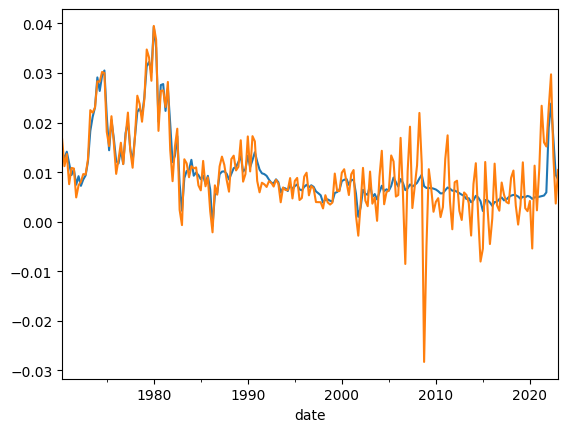

In [ ]:
model.stored_state_means["etau"]["United States"].plot()
df_inflation.query("country == 'United States'").set_index("date")["inflation"].plot()

# 4. H-period ahead forecasting

In [ ]:
df_inflation

,country,date,inflation
0,Portugal,1970-04-01,0.000000
1,New Zealand,1970-04-01,0.015421
2,Dominican Republic,1970-04-01,-0.001604
3,Finland,1970-04-01,0.008333
4,Ireland,1970-04-01,0.029871
...,...,...,...
7415,Canada,2023-01-01,0.006080
7416,Sweden,2023-01-01,0.014955
7417,Korea,2023-01-01,0.010538
7418,United Kingdom,2023-01-01,0.008814


In [ ]:
model.predict(df_inflation.query("date <= '2022-10-1'"))

,inflation,country,date
0,0.007640,Portugal,2023-01-01
1,0.016995,New Zealand,2023-01-01
2,0.011977,Dominican Republic,2023-01-01
3,0.019959,Finland,2023-01-01
4,0.019124,Ireland,2023-01-01
5,0.020866,Austria,2023-01-01
6,-0.001160,Japan,2023-01-01
7,0.015110,South Africa,2023-01-01
8,0.012964,Korea,2023-01-01
9,0.013758,Fiji,2023-01-01


In [ ]:
from seminartools.models.utils import h_period_ahead_forecast

forecast = h_period_ahead_forecast(model, df_inflation, "2010-01-01", h=1)
forecast

,inflation,country,date
0,0.011139,Portugal,2010-01-01
1,0.004252,New Zealand,2010-01-01
2,0.014421,Dominican Republic,2010-01-01
3,-0.001630,Finland,2010-01-01
4,0.000232,Ireland,2010-01-01
...,...,...,...
1850,0.049453,Italy,2023-01-01
1851,0.018807,United Kingdom,2023-01-01
1852,0.012877,Australia,2023-01-01
1853,0.000688,Spain,2023-01-01


<Axes: xlabel='date'>

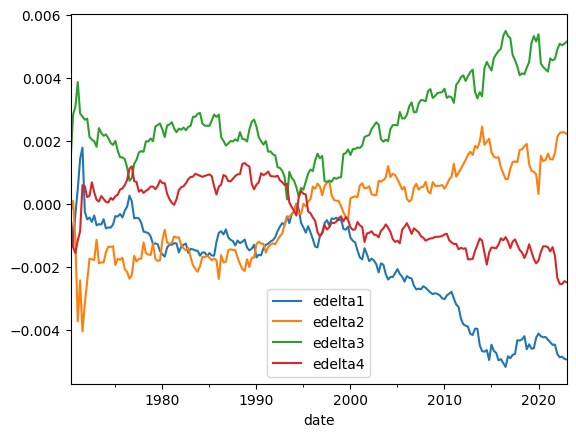

In [ ]:
model.stored_state_means.loc["United States"][["edelta1", "edelta2", "edelta3", "edelta4"]].plot()

Text(0.5, 1.0, 'Forecasts, tau and actual inflation for the US')

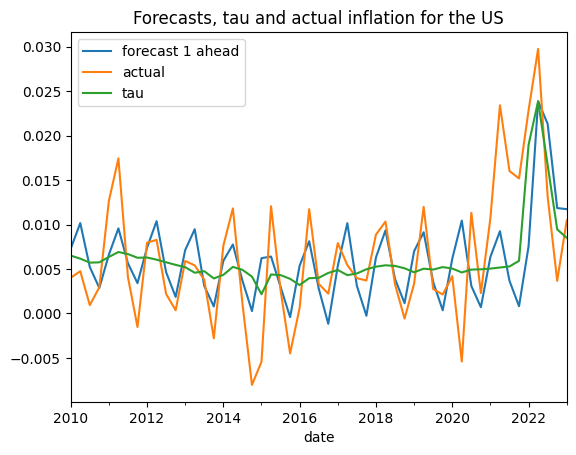

In [ ]:
import matplotlib.pyplot as plt
forecast.query("country == 'United States'").set_index("date")['inflation'].plot(label = "forecast 1 ahead")
df_inflation.query("country == 'United States' and date >= '2010-01-01'").set_index("date")['inflation'].plot(label = "actual")
model.stored_state_means.loc["United States"].loc["2010-01-01":]["etau"].plot(label = "tau")
plt.legend()
plt.title("Forecasts, tau and actual inflation for the US")

Text(0.5, 1.0, 'Tau over time per country')

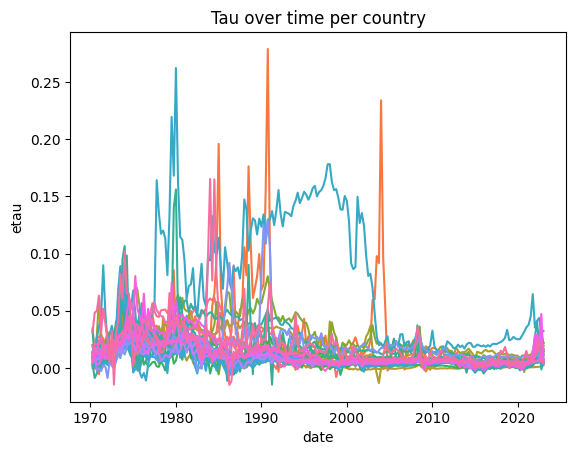

In [ ]:
import seaborn as sns
sns.lineplot(
    data = model.stored_state_means["etau"].to_frame().reset_index(),
    x = "date",
    y = "etau",
    hue = "country"
)
plt.legend().remove()
plt.title("Tau over time per country")

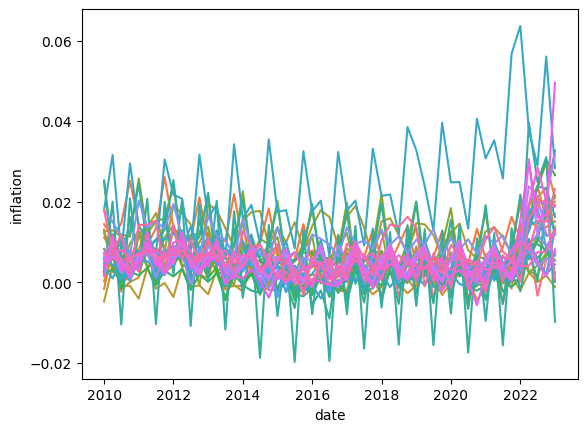

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data = forecast,
    x = "date",
    y = "inflation",
    hue = "country"
)
# turn off legend
plt.legend().remove()

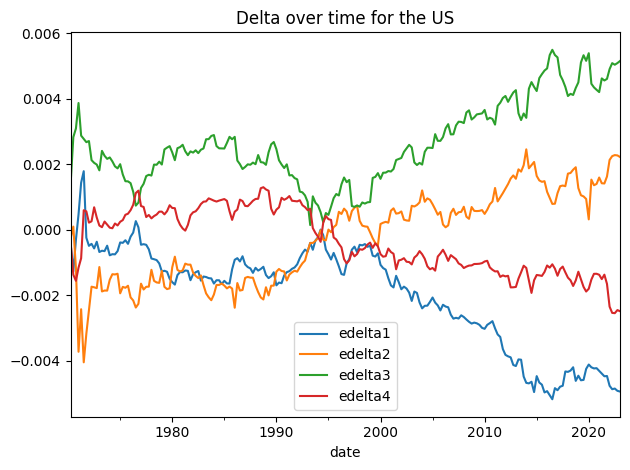

In [ ]:
model.stored_state_means.loc["United States"][["edelta1", "edelta2", "edelta3", "edelta4"]].plot()
plt.title("Delta over time for the US")
plt.tight_layout()
plt.savefig("../../Figures/delta_over_time.png", dpi = 300)

# 5. Compare the forecast with the actual data

In [ ]:
forecast_merged = forecast.copy().rename(columns={"inflation": "pred"})
forecast_merged = forecast_merged.merge(
    df_inflation[["country", "date", "inflation"]],
    on=["country", "date"],
    how="left",
).rename(columns={"inflation": "actual"})
forecast_merged.tail(100)

,pred,country,date,actual
1755,0.023747,Austria,2022-07-01,0.026846
1756,0.000059,Japan,2022-07-01,0.010628
1757,0.013825,South Africa,2022-07-01,0.027957
1758,0.011143,Korea,2022-07-01,0.011352
1759,0.001805,Fiji,2022-07-01,0.007368
...,...,...,...,...
1850,0.049453,Italy,2023-01-01,0.003938
1851,0.018807,United Kingdom,2023-01-01,0.008814
1852,0.012877,Australia,2023-01-01,0.013756
1853,0.000688,Spain,2023-01-01,0.006013


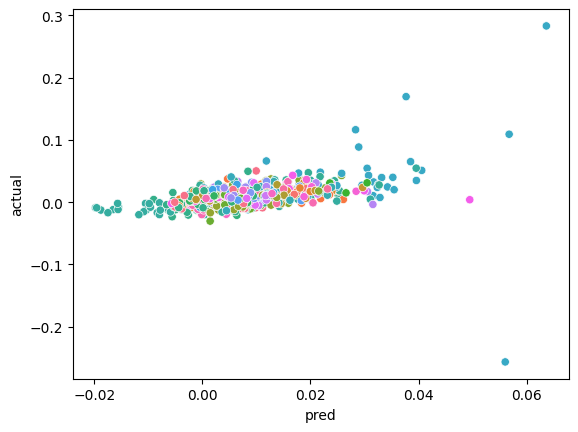

In [ ]:
sns.scatterplot(
    data = forecast_merged,
    x = "pred",
    y = "actual",
    hue = "country"
)
plt.legend().remove()

In [ ]:
import statsmodels.api as sm

sm.OLS(
    forecast_merged["actual"], sm.add_constant(forecast_merged["pred"])
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actual   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     570.0
Date:                Tue, 02 Apr 2024   Prob (F-statistic):          4.63e-110
Time:                        01:00:30   Log-Likelihood:                 5504.0
No. Observations:                1855   AIC:                        -1.100e+04
Df Residuals:                    1853   BIC:                        -1.099e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.152      0.032    7.25e-05       0.002
pred           0.9617      0.040     23.875      0.000       0.883       1.041
==============================================================================
Omnibus:                     2067.032   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5649273.561
Skew:                          -4.346   Prob(JB):                         0.00
Kurtosis:                     273.213   Cond. No.                         139.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#getDensities
from seminartools.models.uc_sv_ss_model import UCSVSSModel
modelDistribution = UCSVSSModel(num_particles=10000, stochastic_seasonality=True)
modelDistribution.run_pf(df_inflation, aggregation_method = "distribution")




100%|██████████| 35/35 [00:08<00:00,  3.90it/s]


In [ ]:
distributionForecast = h_period_ahead_forecast(modelDistribution, df_inflation, "2010-01-01", h=1)


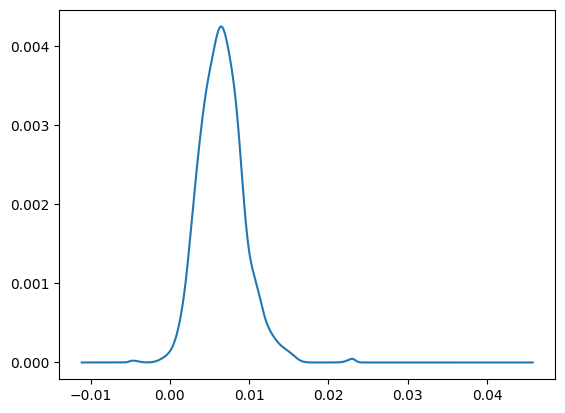

In [ ]:
US_inflation = distributionForecast.query("country == 'United States'").set_index("date")['inflation']

plt.plot(
    US_inflation.iloc[-1]["inflation_grid"],
    US_inflation.iloc[-1]["pdf"]
    )